In [2]:
import base64
#import cStringIO
import sys
import tempfile
import time
MODEL_BASE = '/Users/aadebuger/GEXT/github2019/models/research'
MODEL_BASE = '/home/aadebugergf/Ai/github2019/models/research'


sys.path.append(MODEL_BASE)
sys.path.append(MODEL_BASE + '/object_detection')
sys.path.append(MODEL_BASE + '/slim')


import numpy as np
from PIL import Image
from PIL import ImageDraw
import tensorflow as tf
from utils import label_map_util




PATH_TO_CKPT = '/Users/aadebuger/GEXT/model/ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb'
PATH_TO_LABELS = MODEL_BASE + '/object_detection/data/mscoco_label_map.pbtxt'

content_types = {'jpg': 'image/jpeg',
                 'jpeg': 'image/jpeg',
                 'png': 'image/png'}
extensions = sorted(content_types.keys())


def is_image():
  def _is_image(form, field):
    if not field.data:
      raise ValidationError()
    elif field.data.filename.split('.')[-1].lower() not in extensions:
      raise ValidationError()

  return _is_image





class ObjectDetector(object):

  def __init__(self):
    self.detection_graph = self._build_graph()
    self.sess = tf.Session(graph=self.detection_graph)

    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    self.category_index = label_map_util.create_category_index(categories)

  def _build_graph(self):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    return detection_graph

  def _load_image_into_numpy_array(self, image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

  def detect(self, image):
    image_np = self._load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    graph = self.detection_graph
    image_tensor = graph.get_tensor_by_name('image_tensor:0')
    boxes = graph.get_tensor_by_name('detection_boxes:0')
    scores = graph.get_tensor_by_name('detection_scores:0')
    classes = graph.get_tensor_by_name('detection_classes:0')
    num_detections = graph.get_tensor_by_name('num_detections:0')
    detection_masks = graph.get_tensor_by_name('detection_masks:0')
    print('detection_masks',detection_masks)
    (boxes, scores, classes, num_detections) = self.sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    boxes, scores, classes, num_detections = map(
        np.squeeze, [boxes, scores, classes, num_detections])

    return boxes, scores, classes.astype(int), num_detections


def draw_bounding_box_on_image(image, box, color='red', thickness=4):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  ymin, xmin, ymax, xmax = box
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  print("rect,width="+str(right-left)+"height="+str(bottom-top))
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  print('(left, right, top, bottom)',(left, right, top, bottom))

from io import BytesIO
def encode_image(image):
  image_buffer = BytesIO()
  image.save(image_buffer, format='PNG')
  imagevalue = image_buffer.getvalue()
  base64str=base64.b64encode(imagevalue).decode()

  imgstr = 'data:image/png;base64,{:s}'.format(
     base64str )
  return imgstr


def detect_objects(image_path):
  start = time.time()
  
  image = Image.open(image_path).convert('RGB')
  boxes, scores, classes, num_detections = client.detect(image)
  end = time.time()
  print("execute1 time",(end-start)) 
    
  image.thumbnail((480, 480), Image.ANTIALIAS)
  print(num_detections)
  new_images = {}
  for i in range(int(num_detections)):

    if scores[i] < 0.35: continue
    print("scres[i",scores[i])
        
    cls = classes[i]
    if cls not in new_images.keys():
      new_images[cls] = image.copy()
    print("boxes",boxes[i])
    draw_bounding_box_on_image(new_images[cls], boxes[i],
                               thickness=int(scores[i]*10)-4)

  result = {}
#  result['original'] = encode_image(image.copy())
  print(new_images)
  count = 0 
  for cls, new_image in new_images.items():
    category = client.category_index[cls]['name']
    print(category)
    result[category] = encode_image(new_image)
    new_image.save("{0}.jpg".format(count))
    count=count+1
  end = time.time()
  print("execute2 time",(end-start)) 
  return result



PATH_TO_CKPT='/Users/aadebuger/GEXT/model/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb'
PATH_TO_CKPT='/home/aadebugergf/Ai/models/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb'

PATH_TO_CKPT='/home/aadebugergf/Ai/models/mask_rcnn_inception_v2_cocortx0715/frozen_inference_graph.pb'

client = ObjectDetector()

detection_masks Tensor("detection_masks:0", shape=(?, 300, 15, 15), dtype=float32)
execute1 time 1.2647714614868164
100.0
scres[i 0.9999902
boxes [0.31828877 0.5808748  0.599911   0.7934999 ]
rect,width=102.0600414276123height=101.38399243354797
(left, right, top, bottom) (278.8199043273926, 380.8799457550049, 114.58395838737488, 215.96795082092285)
scres[i 0.95730597
boxes [0.3047791  0.5924562  0.73241246 0.7603753 ]
rect,width=80.60116767883301height=153.94800424575806
(left, right, top, bottom) (284.3789863586426, 364.9801540374756, 109.72048044204712, 263.6684846878052)
{1: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F22B8480048>}
person
execute2 time 1.361656665802002
1



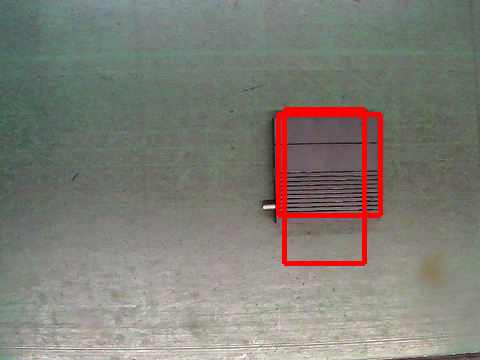

In [12]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426121940.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['person']))

detection_masks Tensor("detection_masks:0", shape=(?, 300, 15, 15), dtype=float32)
execute1 time 0.28471851348876953
100.0
scres[i 0.9999902
boxes [0.31828877 0.5808748  0.599911   0.7934999 ]
rect,width=102.0600414276123height=101.38399243354797
(left, right, top, bottom) (278.8199043273926, 380.8799457550049, 114.58395838737488, 215.96795082092285)
scres[i 0.95730597
boxes [0.3047791  0.5924562  0.73241246 0.7603753 ]
rect,width=80.60116767883301height=153.94800424575806
(left, right, top, bottom) (284.3789863586426, 364.9801540374756, 109.72048044204712, 263.6684846878052)
{1: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F22B84310F0>}
person
execute2 time 0.35077404975891113
1



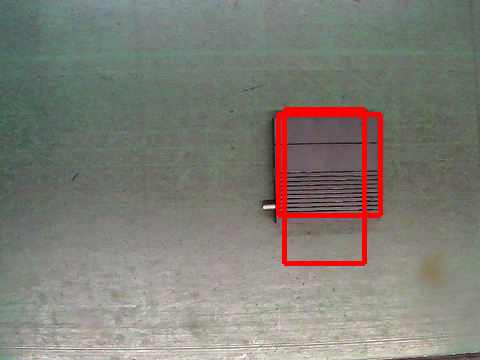

In [13]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426121940.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['person']))

detection_masks Tensor("detection_masks:0", shape=(?, 300, 15, 15), dtype=float32)
execute1 time 0.27809882164001465
100.0
scres[i 1.0
boxes [0.70976233 0.2818727  0.9652967  0.4753208 ]
rect,width=92.85508632659912height=91.99236631393433
(left, right, top, bottom) (135.29889106750488, 228.153977394104, 255.51444053649902, 347.50680685043335)
{1: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F22B84310F0>}
person
execute2 time 0.3578181266784668
1



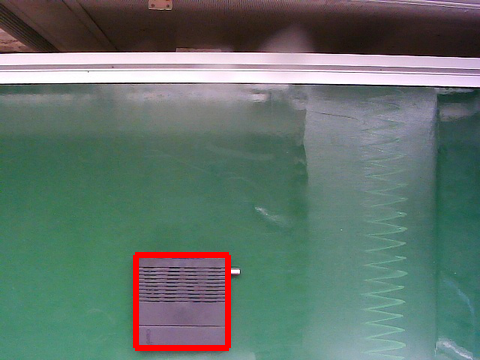

In [14]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/object20190628141813.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['person']))

execute1 time 0.2819862365722656
100.0
scres[i 0.97520363
boxes [0.5847985 0.3724821 0.847389  0.5775819]
rect,width=98.44789981842041height=94.53256845474243
(left, right, top, bottom) (178.79140377044678, 277.2393035888672, 210.52746534347534, 305.0600337982178)
{1: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F23C2ECB320>}
person
execute2 time 0.39500856399536133
1



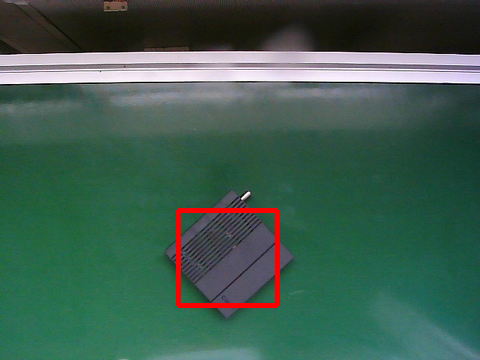

In [9]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/object20190705141654.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['person']))

execute1 time 0.29291844367980957
100.0
scres[i 0.97520363
boxes [0.5847985 0.3724821 0.847389  0.5775819]
rect,width=98.44789981842041height=94.53256845474243
(left, right, top, bottom) (178.79140377044678, 277.2393035888672, 210.52746534347534, 305.0600337982178)
{1: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F22B84809E8>}
person
execute2 time 0.4032161235809326
1



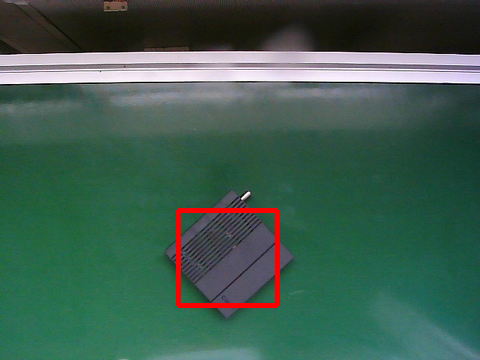

In [10]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/object20190705141654.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['person']))

detection_masks Tensor("detection_masks:0", shape=(?, 300, 15, 15), dtype=float32)
execute1 time 0.2974536418914795
100.0
scres[i 1.0
boxes [0.68103385 0.41280663 0.9387357  0.6036524 ]
rect,width=91.60597801208496height=92.77267456054688
(left, right, top, bottom) (198.1471824645996, 289.75316047668457, 245.17218589782715, 337.944860458374)
{1: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F22B8431198>}
person
execute2 time 0.4116206169128418
1



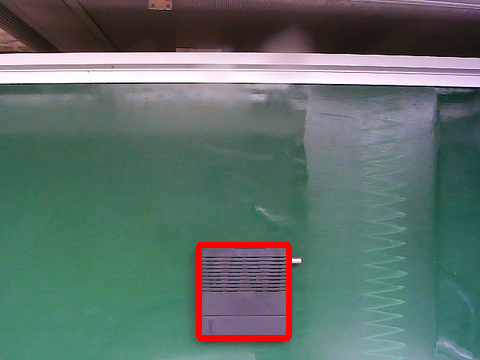

In [15]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/object20190628134640.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['person']))

detection_masks Tensor("detection_masks:0", shape=(?, 300, 15, 15), dtype=float32)
execute1 time 4.883244514465332
100.0
scres[i 0.99999845
boxes [0.33063182 0.59089404 0.61251926 0.78502816]
rect,width=93.18437576293945height=101.47947907447815
(left, right, top, bottom) (283.62914085388184, 376.8135166168213, 119.02745604515076, 220.5069351196289)
{1: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F34788D1E10>}
person
execute2 time 4.954120635986328
1



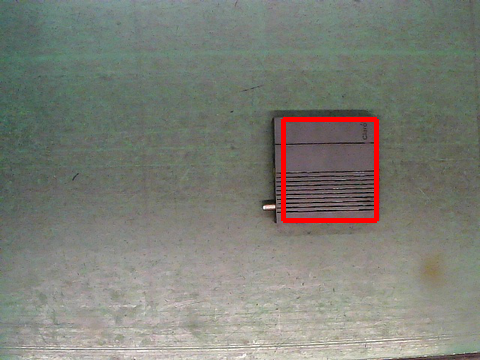

In [3]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426121940.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['person']))

detection_masks Tensor("detection_masks:0", shape=(?, 300, 15, 15), dtype=float32)
execute1 time 0.2896134853363037
100.0
scres[i 0.9582846
boxes [0.5829688  0.37839273 0.84148526 0.56532663]
rect,width=89.72827434539795height=93.06593656539917
(left, right, top, bottom) (181.62850856781006, 271.356782913208, 209.86875772476196, 302.93469429016113)
{1: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F344814AFD0>}
person
execute2 time 0.373852014541626
1



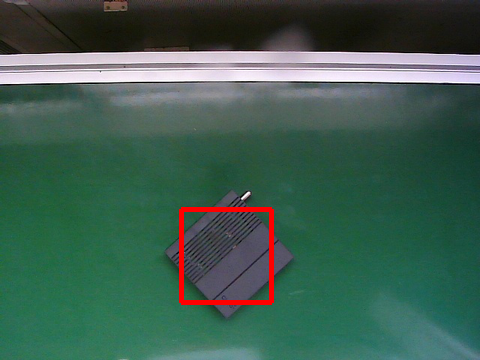

In [4]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/object20190705141654.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['person']))

detection_masks Tensor("detection_masks:0", shape=(?, 300, 15, 15), dtype=float32)
execute1 time 0.2877631187438965
100.0
scres[i 1.0
boxes [0.68183976 0.41279566 0.9399391  0.6040488 ]
rect,width=91.80150032043457height=92.9157543182373
(left, right, top, bottom) (198.14191818237305, 289.9434185028076, 245.46231508255005, 338.37806940078735)
{1: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F344814AEF0>}
person
execute2 time 0.3704192638397217
1



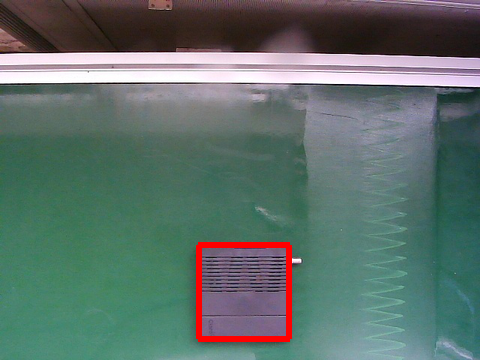

In [5]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/object20190628134640.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['person']))

detection_masks Tensor("detection_masks:0", shape=(?, 300, 15, 15), dtype=float32)
execute1 time 0.29686760902404785
100.0
scres[i 0.99999845
boxes [0.33063182 0.59089404 0.61251926 0.78502816]
rect,width=93.18437576293945height=101.47947907447815
(left, right, top, bottom) (283.62914085388184, 376.8135166168213, 119.02745604515076, 220.5069351196289)
{1: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F344814AF60>}
person
execute2 time 0.36489224433898926
1



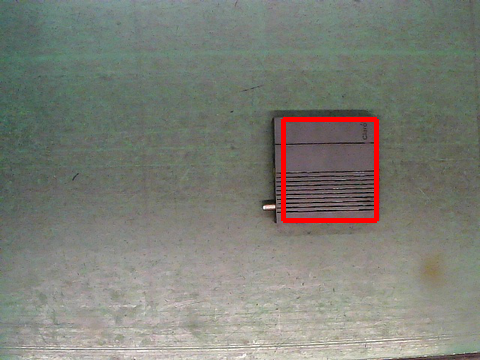

In [6]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426121940.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['person']))

detection_masks Tensor("detection_masks:0", shape=(?, 300, 15, 15), dtype=float32)
execute1 time 0.30127429962158203
100.0
scres[i 1.0
boxes [0.70846397 0.27992666 0.9666421  0.4756111 ]
rect,width=93.92852783203125height=92.94412136077881
(left, right, top, bottom) (134.36479568481445, 228.2933235168457, 255.04702806472778, 347.9911494255066)
{1: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F3448161048>}
person
execute2 time 0.3829317092895508
1



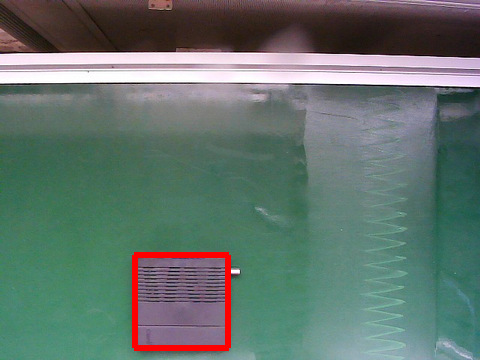

In [7]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/object20190628141813.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['person']))